# Some figures of the paper

Author: Etienne Kornobis, Thomas Cokelaer, 2021-2022

Scripts from Sequana https://sequana.readthedocs.io

Data from https://github.com/sequana/mapper pipeline *

Data from notebooks 3_report.ipynb and stored in data/ for speed

In [2]:
INFO_FILE = "info.json"


In [3]:
import json
from pathlib import Path
import pandas as pd
import parse
import sys
import pysam
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import shutil
from collections import Counter

%matplotlib inline
matplotlib.style.use('seaborn-colorblind')
matplotlib.pyplot.rcParams['figure.figsize'] = 14, 6

pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.1f}'.format



# Design

Information on the capture kits, sequencing technologies, runs and sample groups.

In [4]:
with open(INFO_FILE, "r") as f:
    info = json.load(f)

groups_df = pd.DataFrame(info["groups"]).melt().rename(columns={'variable': 'group', 'value': 'sample_id'})
groups_df = groups_df.astype({'sample_id':str})
cts_df = pd.DataFrame(info["cts"], index=["ct"]).transpose().reset_index().rename(columns={'index': 'sample_id'})
# Joining groups and cts
groups_df = cts_df.merge(groups_df, on="sample_id")



In [5]:
design_df = pd.DataFrame(info["runs"]).transpose().reset_index().rename(columns={'index':'experiment'})


# Precomputed ontarget data

In [6]:
dfs_ontarget = pd.read_csv("data/ontarget_data.csv", index_col=0)
dfs_ontarget['sample_id'] = [str(x) for x in dfs_ontarget['sample_id']]

# Utilities functions

In [7]:
from collections import defaultdict
from tqdm import tqdm



def get_ref_bam_stats(bamfile):
    names = defaultdict(int)
    b = pysam.AlignmentFile(bamfile, 'rb')
    #count = 0
    for a in tqdm(b):
        names[a.reference_name]+=1
        #count +=1
        #if count == 100000:
        #    break
    
    res = {
        "human": sum([names[x] for x in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', 
                                        '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y']]),
        "SARS-CoV-2": names['MN908947.3'],
        "other": names[None],
    }
    res['total'] = res['human'] + res['other'] + res['SARS-CoV-2']
    return res

def get_on_target_mapping_stats(analysis_dirs, dir_pattern="*"):
    all_dfs = []

    for count, analysis_dir in enumerate(analysis_dirs):
        
        bams_pattern = "**/bowtie2_mapping_ref/*sorted.bam"
        experiment = analysis_dir.stem
        
        for bam in analysis_dir.glob(bams_pattern):
            print(bam)
            
            sample_id = bam.stem.split("_")[0]
            map_stats = get_ref_bam_stats(bam)
            map_stats["experiment"] = experiment
            map_stats["sample_id"] = sample_id
            all_dfs.append(map_stats)
            
    return pd.DataFrame(all_dfs)

def aggregate_target_dfs(dfs_list):
    df = pd.DataFrame(dfs_list)
    df = df.set_index(["sample_id", "experiment"])
    df = df.divide(df.total, axis=0).reset_index()
    df = df.merge(groups_df, on="sample_id")
    df = df.sort_values("ct")
    df = df.astype({"ct": str})
    df = df.query("sample_id not in ['4510', 4510]")
    return df

def plot_barplot(df, title="", ax=None, legend=False, legendy=1.11):
    #fig, ax = plt.subplots()
    cmap = sns.color_palette("colorblind", as_cmap=True)
    ax.bar(df.ct, df.loc[:,"SARS-CoV-2"], label='SARS-CoV-2', color=cmap[2])
    ax.bar(df.ct, df.human, label='human', bottom=df.loc[:, "SARS-CoV-2"], color=cmap[0])
    ax.bar(df.ct, df.other, bottom=df.human + df.loc[:,"SARS-CoV-2"],
       label='unmapped', color=cmap[1])
    if legend:
        ax.legend(bbox_to_anchor=(legendy, 0.5), loc=10, borderaxespad=0.)
    ax.set_xticklabels(df.ct, rotation=45)
    ax.set_title(title)

# Figure Illumina

/home/cokelaer/miniconda3/envs/sequana/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/cokelaer/miniconda3/envs/sequana/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


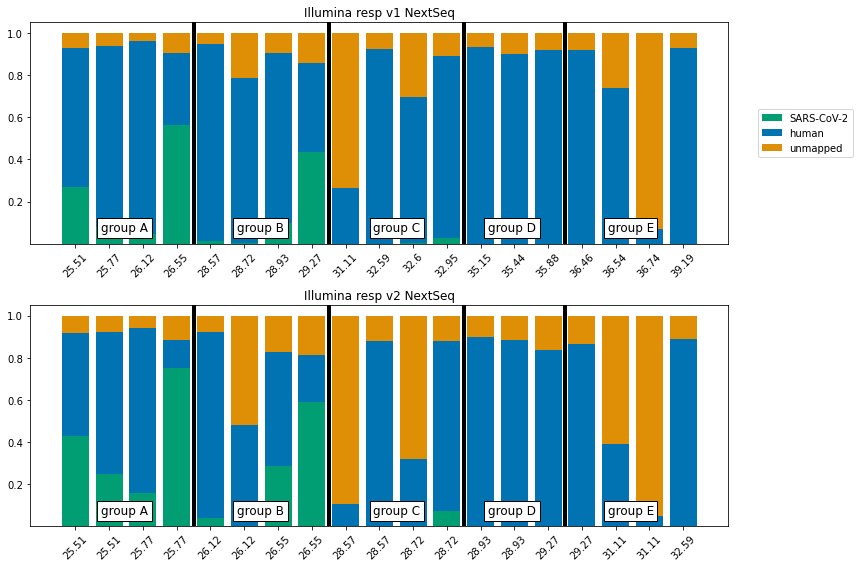

In [11]:
matplotlib.pyplot.rcParams['figure.figsize'] = 12, 8
figure, ax = plt.subplots(2, 1)

plot_barplot(aggregate_target_dfs(dfs_ontarget).query("experiment == 'illumina_resv_ns' "),
            title="Illumina resp v1 NextSeq", ax=ax[0], legend=True)

plot_barplot(aggregate_target_dfs(dfs_ontarget).query("experiment == 'illumina_resv_v2_ns' "),
            title="Illumina resp v2 NextSeq", ax=ax[1])

plt.tight_layout()

axes = plt.gcf().get_axes()
for ax in axes:
    for x in [3.5,7.5,11.5,14.5]: 
        ax.axvline(x, lw=4, color='k')

    ax.annotate('group A', xy=(0.5, 0.90), xytext=(0.135, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top', rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )
    ax.annotate('group B', xy=(0.5, 0.90), xytext=(0.33, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top', rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )
    ax.annotate('group C', xy=(0.5, 0.90), xytext=(0.525, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top',  rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )
    ax.annotate('group D', xy=(0.5, 0.90), xytext=(0.69, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top',  rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )
    ax.annotate('group E', xy=(0.5, 0.90), xytext=(0.86, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top',  rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )

for x in ['png', 'eps', 'pdf']:
    plt.savefig(f"images/6_figpaper/Illumina_v1__and__v2.{x}", dpi=200)



# Figure 4 B

/home/cokelaer/miniconda3/envs/sequana/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/cokelaer/miniconda3/envs/sequana/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


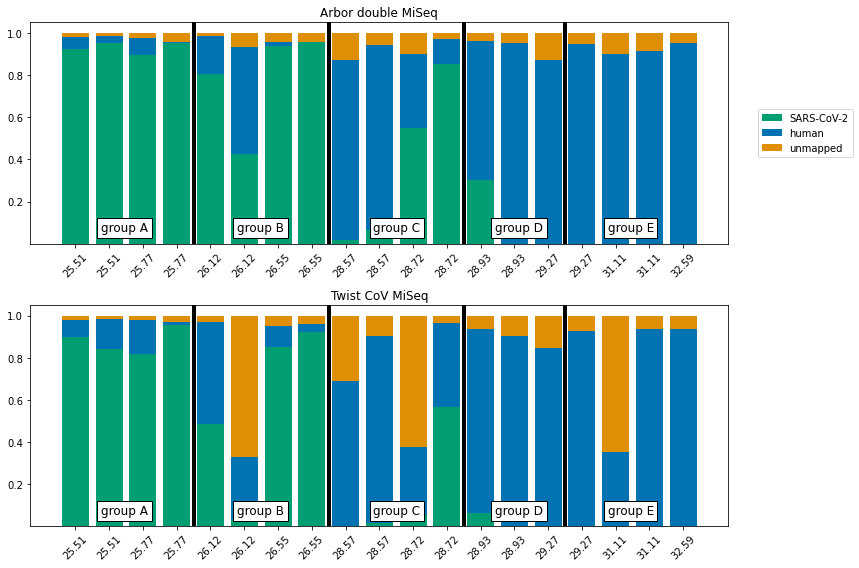

In [13]:
matplotlib.pyplot.rcParams['figure.figsize'] = 12, 8
figure, ax = plt.subplots(2, 1)

plot_barplot(aggregate_target_dfs(dfs_ontarget).query("experiment == 'arbo_double_ms' "),
            title="Arbor double MiSeq", ax=ax[0], legend=True)



plot_barplot(aggregate_target_dfs(dfs_ontarget).query("experiment == 'twist_cov_ms' "),
            title="Twist CoV MiSeq", ax=ax[1])

plt.tight_layout()

axes = plt.gcf().get_axes()
for ax in axes:
    for x in [3.5,7.5,11.5,14.5]: 
        ax.axvline(x, lw=4, color='k')

    ax.annotate('group A', xy=(0.5, 0.90), xytext=(0.135, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top', rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )
    ax.annotate('group B', xy=(0.5, 0.90), xytext=(0.33, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top', rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )
    ax.annotate('group C', xy=(0.5, 0.90), xytext=(0.525, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top',  rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )
    ax.annotate('group D', xy=(0.5, 0.90), xytext=(0.7, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top',  rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )
    ax.annotate('group E', xy=(0.5, 0.90), xytext=(0.86, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top',  rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )

for x in ['png', 'eps', 'pdf']:
    plt.savefig(f"images/6_figpaper/figure4_B.{x}", dpi=200)


#dfs_ontarget_ti.to_csv("ontarget_twist_panviral_vsillumina.csv")

# Figure 4A

/home/cokelaer/miniconda3/envs/sequana/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/cokelaer/miniconda3/envs/sequana/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


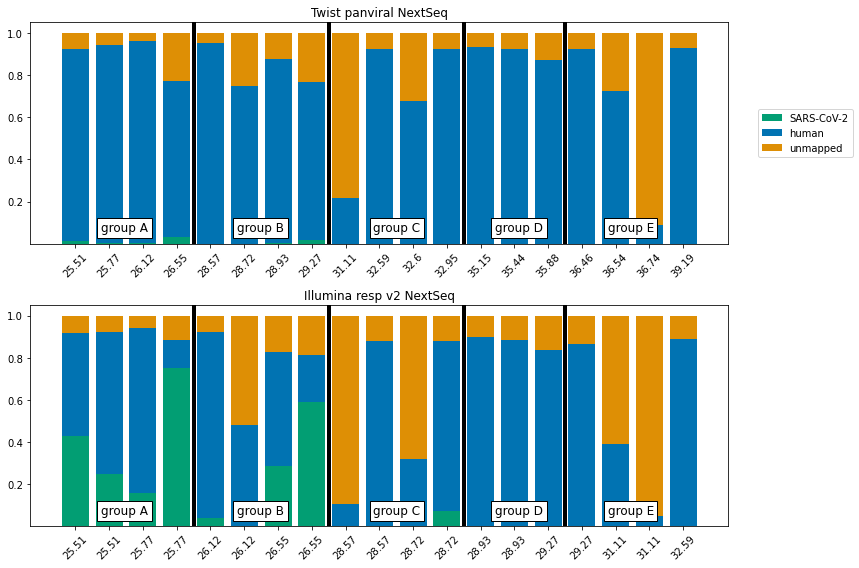

In [15]:
matplotlib.pyplot.rcParams['figure.figsize'] = 12, 8
figure, ax = plt.subplots(2, 1)

plot_barplot(aggregate_target_dfs(dfs_ontarget).query("experiment == 'twist_panviral_ns' "),
            title="Twist panviral NextSeq", ax=ax[0], legend=True)



plot_barplot(aggregate_target_dfs(dfs_ontarget).query("experiment == 'illumina_resv_v2_ns' "),
            title="Illumina resp v2 NextSeq", ax=ax[1])

plt.tight_layout()

axes = plt.gcf().get_axes()
for ax in axes:
    for x in [3.5,7.5,11.5,14.5]: 
        ax.axvline(x, lw=4, color='k')

    ax.annotate('group A', xy=(0.5, 0.90), xytext=(0.135, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top', rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )
    ax.annotate('group B', xy=(0.5, 0.90), xytext=(0.33, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top', rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )
    ax.annotate('group C', xy=(0.5, 0.90), xytext=(0.525, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top',  rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )
    ax.annotate('group D', xy=(0.5, 0.90), xytext=(0.70, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top',  rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )
    ax.annotate('group E', xy=(0.5, 0.90), xytext=(0.86, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top',  rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )

for x in ['png', 'eps', 'pdf']:
    plt.savefig(f"images/6_figpaper/figure4_A.{x}", dpi=200)


#dfs_ontarget_ti.to_csv("ontarget_twist_panviral_vsillumina.csv")

# Figure S1 

/home/cokelaer/miniconda3/envs/sequana/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/cokelaer/miniconda3/envs/sequana/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/cokelaer/miniconda3/envs/sequana/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


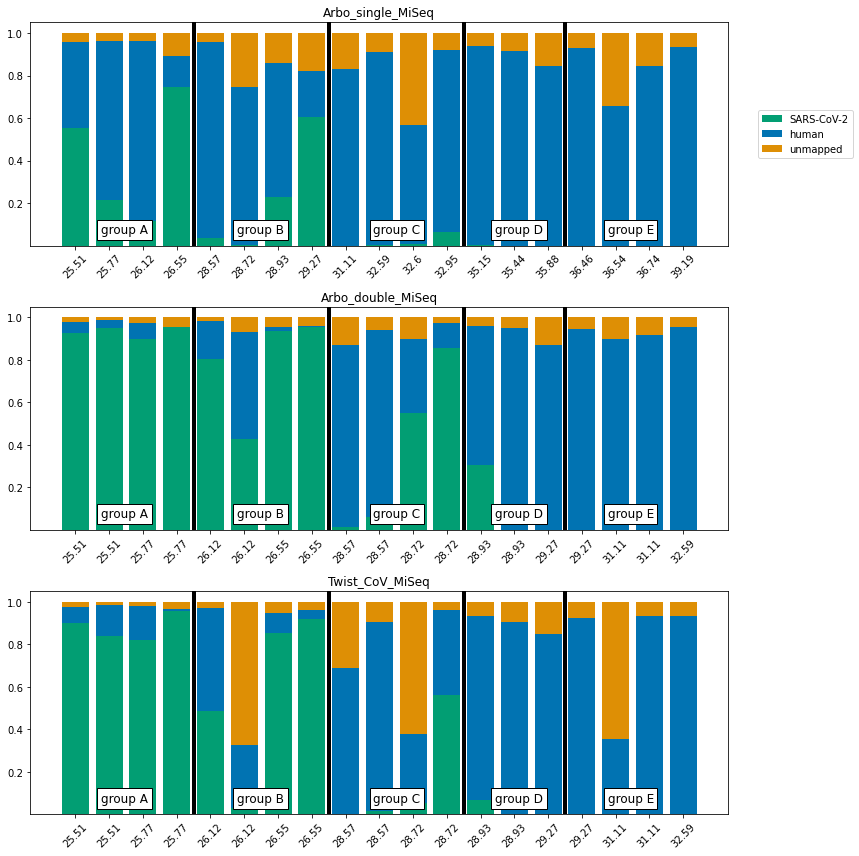

In [16]:
matplotlib.pyplot.rcParams['figure.figsize'] = 12, 12
figure, ax = plt.subplots(3, 1) 

plot_barplot(aggregate_target_dfs(dfs_ontarget).query("experiment == 'arbo_single_ms' "),
            title="Arbo_single_MiSeq", ax=ax[0], legend=True)
plot_barplot(aggregate_target_dfs(dfs_ontarget).query("experiment == 'arbo_double_ms' "),
            title="Arbo_double_MiSeq", ax=ax[1])
plot_barplot(aggregate_target_dfs(dfs_ontarget).query("experiment == 'twist_cov_ms' "),
            title="Twist_CoV_MiSeq", ax=ax[2])
plt.tight_layout()

axes = plt.gcf().get_axes()
for ax in axes:
    for x in [3.5,7.5,11.5,14.5]: 
        ax.axvline(x, lw=4, color='k')

    ax.annotate('group A', xy=(0.5, 0.90), xytext=(0.135, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top', rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )
    ax.annotate('group B', xy=(0.5, 0.90), xytext=(0.33, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top', rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )
    ax.annotate('group C', xy=(0.5, 0.90), xytext=(0.525, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top',  rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )
    ax.annotate('group D', xy=(0.5, 0.90), xytext=(0.70, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top',  rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )
    ax.annotate('group E', xy=(0.5, 0.90), xytext=(0.86, 0.1), xycoords='axes fraction', 
            fontsize=8*1.5, ha='center', va='top',  rotation=0,
            bbox=dict(boxstyle='square', fc='white')
            )

for x in ['png', 'eps', 'pdf']:
    plt.savefig(f"images/6_figpaper/figure_S1.{x}", dpi=200)

